In [0]:
!nvidia-smi

Sat May 23 03:26:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install watermark

In [0]:
from google.colab import files
files.upload()

Saving load_data.py to load_data.py


{'load_data.py': b'# -*- coding: utf-8 -*-\r\n"""\r\nCreated on Fri May 22 13:06:26 2020\r\n\r\n@author: dayan\r\n"""\r\nimport os\r\nimport tensorflow as tf\r\nimport pandas as pd\r\nimport numpy as np\r\nfrom scipy.io import loadmat\r\n\r\n\r\ndef Input_image(image):\r\n    images = loadmat(image).get(\'rad\')\r\n    return images[0:500:2, 0:500:2, 0:3]\r\n\r\n\r\ndef Oput_image(image):\r\n    images = loadmat(image).get(\'rad\')\r\n    return images[:, :,0 :12]\r\n\r\n\r\ndef load_sambles(data):\r\n    data = data[[\'inimg\']]\r\n    inimg_name = list(data.iloc[:, 0])\r\n    samples = []\r\n    for samp in inimg_name:\r\n        samples.append(samp)\r\n    return samples\r\n\r\ndef conv_array(samples, lenData, PATH, IMG_WIDTH, IMG_HEIGHT, L_imput, L_bands, shuffle=True):\r\n\r\n    X = np.empty((lenData, IMG_WIDTH, IMG_HEIGHT, L_imput )) \r\n    y = np.empty((lenData, 2 * IMG_WIDTH, 2 * IMG_HEIGHT, L_bands))\r\n    \r\n    for i, file_name in enumerate(samples):\r\n        # Store s

In [0]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from load_data import *
#modulos para red
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization, UpSampling2D, Flatten, Conv2D, Conv2DTranspose, LeakyReLU,PReLU, add, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

#manipulación de datos
import numpy as np
import pandas as pd

#manipulación de imagenes
from skimage import io, segmentation as seg
from skimage.transform import resize
from PIL import Image

#visualización de imagenes
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import scipy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%reload_ext watermark
%watermark -a "Christian Dayan Arcos Gordillo" --iversion

In [0]:
dataset_path = "/content/drive/My Drive/Formated-20200425T014201Z-005.zip"
zip_object = zipfile.ZipFile(file=dataset_path,mode='r')
zip_object.extractall('./dataset/')
zip_object.close()

In [0]:
PATH = './dataset/Formated/'
# parameters of the net
BATCH_SIZE = 36; IMG_WIDTH = 250; IMG_HEIGHT = 250; L_bands    = 12; L_imput    = 3

In [0]:
(x_train_lr, x_train_hr),(x_test_lr, x_test_hr) = Build_data_set(IMG_WIDTH=IMG_WIDTH,IMG_HEIGHT=IMG_HEIGHT,
                                          L_bands=L_bands,L_imput=L_imput,BATCH_SIZE=BATCH_SIZE,PATH=PATH)

In [0]:
print('train_hr sahpe ', x_train_hr.shape)
print('train_lr sahpe ', x_train_lr.shape)
print('test_hr sahpe ', x_test_hr.shape)
print('test_lr  sahpe ', x_test_lr.shape)

train_hr sahpe  (29, 500, 500, 12)
train_lr sahpe  (29, 250, 250, 3)
test_hr sahpe  (7, 500, 500, 12)
test_lr  sahpe  (7, 250, 250, 3)


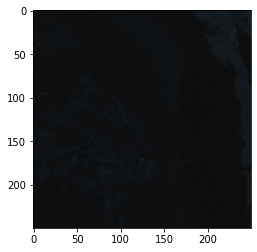

In [0]:
plt.imshow(x_train_lr[1])
plt.show()

In [0]:
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model

In [0]:
def up_sampling_block(model, kernal_size, filters, strides):

    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [0]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [0]:
class Generator(object):

    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape

    def generator(self):
        
	    gen_input = Input(shape = self.noise_shape)
	    
	    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
	    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
	    
	    gen_model = model
        
        # Using 16 Residual Blocks
	    for index in range(16):
	        model = res_block_gen(model, 3, 64, 1)
	    
	    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
	    model = BatchNormalization(momentum = 0.5)(model)
	    model = add([gen_model, model])
	    
	    # Using 2 UpSampling Blocks
	    for index in range(1):
	        model = up_sampling_block(model, 3, 256, 1)
	    
	    model = Conv2D(filters = 12, kernel_size = 9, strides = 1, padding = "same")(model)
	    model = Activation('tanh')(model)
	   
	    generator_model = Model(inputs = gen_input, outputs = model)
        
	    return generator_model
    

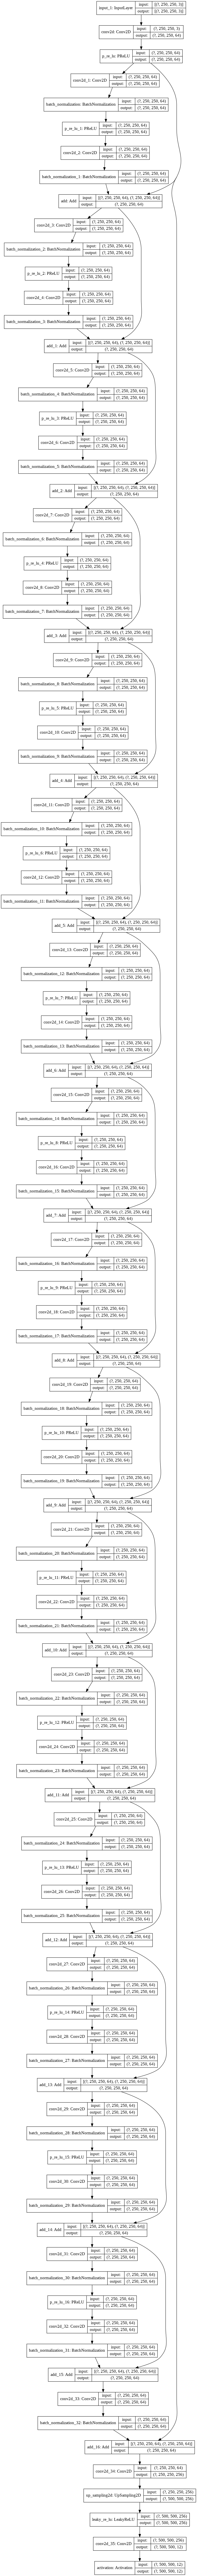

In [0]:
image_shape = x_train_hr[1].shape
downscale_factor=2
shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, L_imput)
generator = Generator(shape).generator()
plot_model(generator,show_shapes=True)

In [0]:
generator.summary()

NameError: ignored

In [0]:
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        
        return discriminator_model


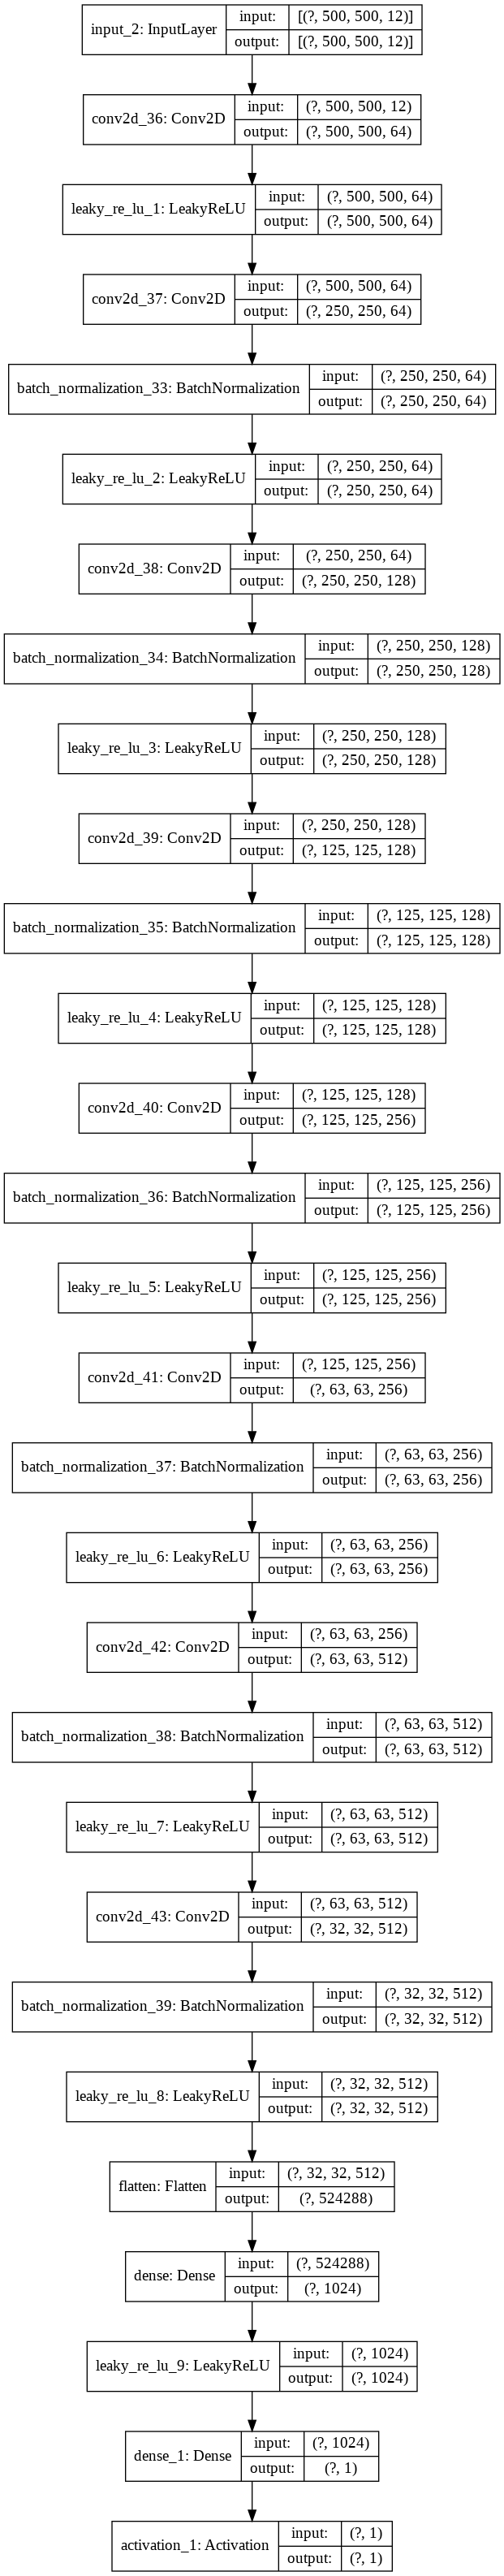

In [0]:
discriminator = Discriminator(x_train_hr.shape[1:]).discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer='adam')
plot_model(discriminator,show_shapes=True)

In [0]:
discriminator.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 500, 500, 12)]    0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 500, 500, 64)      6976      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 500, 500, 64)      0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 250, 250, 64)      36928     
_________________________________________________________________
batch_normalization_113 (Bat (None, 250, 250, 64)      256       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 250, 250, 64)      0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 250, 250, 128)     7385

In [0]:
def vgg_loss(y_true, y_pred):
    return 20*tf.reduce_mean(tf.norm(y_true - y_pred, ord=2, axis=-1)) + tf.reduce_mean(tf.norm(y_true - y_pred, ord='fro', axis=[1,2]))


In [0]:
def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [0]:
import shutil
if os.path.isdir(os.getcwd() +'/output'):
  print('directorio ya existe... removiendo y creando uno nuevo...')
  shutil.rmtree(os.getcwd() + '/output')
  os.makedirs(os.getcwd() + '/output')
else:
  os.makedirs(os.getcwd() + '/output')

directorio ya existe... removiendo y creando uno nuevo...


In [0]:
#Entrenamiento

from tqdm import tqdm
import numpy as np
import argparse
image_shape = x_train_hr[1].shape
downscale_factor=2

def train(epochs=1, batch_size=128):

    #downscale_factor = 4
    
    batch_count = int(x_train_hr.shape[0] / batch_size)
    shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, L_imput)
    
    generator = Generator(shape).generator()
    discriminator = Discriminator(image_shape).discriminator()

    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    generator.compile(loss=vgg_loss, optimizer=adam)
    discriminator.compile(loss="binary_crossentropy", optimizer=adam)
    
    gan = get_gan_network(discriminator, shape, generator, adam)

    for e in range(1, epochs+1):
        print ('*'*15, 'Epoch %d' % e, '*'*15, '\n')
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            loss_gan = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
        print('Discriminator loss : {} \n'.format(d_loss))
        print("Loss HR , Loss LR, Loss GAN")
        print(d_loss_real, d_loss_fake, loss_gan)

        #if e == 1 or e % 10 == 0:
         #   plot_generated_images(e, generator)
        if e % 20 == 0:
            generator.save('./output/gen_model%d.h5' % e)
            discriminator.save('./output/dis_model%d.h5' % e)
            gan.save('./output/gan_model%d.h5' % e)




In [0]:
!nvidia-smi

Sat May 23 03:32:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
train(20,2)

  0%|          | 0/14 [00:00<?, ?it/s]

*************** Epoch 1 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 10.103941440582275 

Loss HR , Loss LR, Loss GAN
11.065876960754395 9.142005920410156 [113.61604309082031, 113.52757263183594, 88.47269439697266]
*************** Epoch 2 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 16.544843673706055 

Loss HR , Loss LR, Loss GAN
5.513828277587891 27.57585906982422 [55.359283447265625, 55.351898193359375, 7.383633136749268]
*************** Epoch 3 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 7.05226469039917 

Loss HR , Loss LR, Loss GAN
5.937848091125488 8.166681289672852 [55.463226318359375, 55.41740798950195, 45.8173828125]
*************** Epoch 4 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 3.9419922828674316 

Loss HR , Loss LR, Loss GAN
3.7106666564941406 4.173317909240723 [46.33287048339844, 46.242618560791016, 90.25019073486328]
*************** Epoch 5 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 3.3615241646766663 

Loss HR , Loss LR, Loss GAN
5.068142890930176 1.6549054384231567 [30.330245971679688, 30.2939510345459, 36.29474639892578]
*************** Epoch 6 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 16.72684383392334 

Loss HR , Loss LR, Loss GAN
10.183549880981445 23.270137786865234 [37.75458526611328, 37.61589813232422, 138.68820190429688]
*************** Epoch 7 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 9.62607479095459 

Loss HR , Loss LR, Loss GAN
2.2463245391845703 17.00582504272461 [45.62821578979492, 45.457176208496094, 171.04115295410156]
*************** Epoch 8 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 9.033503770828247 

Loss HR , Loss LR, Loss GAN
13.648279190063477 4.418728351593018 [18.83258819580078, 18.591150283813477, 241.43841552734375]
*************** Epoch 9 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 16.200512886047363 

Loss HR , Loss LR, Loss GAN
14.224124908447266 18.17690086364746 [28.35536766052246, 28.34507179260254, 10.296285629272461]
*************** Epoch 10 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 10.458958208560944 

Loss HR , Loss LR, Loss GAN
19.134647369384766 1.7832690477371216 [15.207680702209473, 15.153757095336914, 53.92338943481445]
*************** Epoch 11 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 16.369688034057617 

Loss HR , Loss LR, Loss GAN
12.886295318603516 19.85308074951172 [26.298480987548828, 26.188539505004883, 109.94184875488281]
*************** Epoch 12 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 14.39645004272461 

Loss HR , Loss LR, Loss GAN
20.075572967529297 8.717327117919922 [17.789770126342773, 17.707172393798828, 82.59725189208984]
*************** Epoch 13 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 8.461920738220215 

Loss HR , Loss LR, Loss GAN
5.6484222412109375 11.275419235229492 [25.6959171295166, 25.66419219970703, 31.724262237548828]
*************** Epoch 14 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 4.868790358304977 

Loss HR , Loss LR, Loss GAN
9.079887390136719 0.6576933264732361 [26.167823791503906, 26.013120651245117, 154.7029266357422]
*************** Epoch 15 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 4.27962601184845 

Loss HR , Loss LR, Loss GAN
6.941317558288574 1.6179344654083252 [24.906543731689453, 24.864925384521484, 41.61878204345703]
*************** Epoch 16 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 4.423418879508972 

Loss HR , Loss LR, Loss GAN
5.953624725341797 2.8932130336761475 [19.27667808532715, 19.23766326904297, 39.015480041503906]
*************** Epoch 17 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 8.165346145629883 

Loss HR , Loss LR, Loss GAN
9.089963912963867 7.240728378295898 [15.4065580368042, 15.400050163269043, 6.5078558921813965]
*************** Epoch 18 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 6.136458396911621 

Loss HR , Loss LR, Loss GAN
4.652646064758301 7.620270729064941 [17.56795883178711, 17.462095260620117, 105.86270141601562]
*************** Epoch 19 *************** 



  0%|          | 0/14 [00:00<?, ?it/s]

Discriminator loss : 10.279425621032715 

Loss HR , Loss LR, Loss GAN
9.842216491699219 10.716634750366211 [12.7310209274292, 12.705503463745117, 25.5172176361084]
*************** Epoch 20 *************** 



100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


Discriminator loss : 22.7152738571167 

Loss HR , Loss LR, Loss GAN
7.749700546264648 37.68084716796875 [19.32231903076172, 19.291105270385742, 31.212841033935547]


In [0]:
def plot_test_generated_images_for_model(output_dir, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):
    
    examples = x_test_hr.shape[0]
    image_batch_hr = denormalize(x_test_hr)
    image_batch_lr = x_test_lr
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    
    for index in range(examples):
    
        plt.figure(figsize=figsize)
    
        plt.subplot(dim[0], dim[1], 1)
        plt.imshow(image_batch_lr[index], interpolation='nearest')
        plt.axis('off')
        
        plt.subplot(dim[0], dim[1], 2)
        plt.imshow(generated_image[index], interpolation='nearest')
        plt.axis('off')
    
        plt.subplot(dim[0], dim[1], 3)
        plt.imshow(image_batch_hr[index], interpolation='nearest')
        plt.axis('off')
    
        plt.tight_layout()
        plt.savefig(output_dir + 'test_generated_image_%d.png' % index)
    
        #plt.show()

In [0]:
def plot_test_generated_images(output_dir, generator, x_test_lr, figsize=(5, 5)):
    
    examples = x_test_lr.shape[0]
    image_batch_lr = denormalize(x_test_lr)
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    
    for index in range(examples):
    
        #plt.figure(figsize=figsize)
    
        plt.imshow(generated_image[index], interpolation='nearest')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_dir + 'high_res_result_image_%d.png' % index)
    
        #plt.show()

In [0]:
#Test
def test_model(model,output_dir, x_test_hr, x_test_lr):

  plot_test_generated_images_for_model(output_dir, model, x_test_hr, x_test_lr)



In [0]:
from tensorflow.keras.models import load_model
model = load_model('./output/gen_model20.h5', custom_objects={'vgg_loss': vgg_loss})